_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Student name: Kathrin Root, Alexander Wendt, Patrick Weygoldt 

# Coding Lab 3

- __Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `scipy.signal.decimate`.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-05-09 23:40:07CEST

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.11.0

sklearn: 0.0.post1

seaborn   : 0.12.2
matplotlib: 3.7.1
pandas    : 1.5.3
scipy     : 1.10.1
oasis     : 0.2.0
numpy     : 1.24.3

Watermark: 2.3.1



In [ ]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [ ]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)

In [ ]:
ogb_calcium.shape, ogb_spikes.shape, gcamp_calcium.shape, gcamp_spikes.shape

((71986, 11), (71986, 11), (23973, 37), (23973, 37))

In [ ]:
ogb_spikes.head()
ogb_calcium.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.234928,0.689186,2.578560,0.636770,-0.015140,0.819771,2.442105,0.391310,0.223523,1.557675,0.625052
1,-0.182441,0.869132,2.868601,0.596164,0.022464,0.831411,2.930201,0.490213,0.116095,1.628054,0.638718
2,-0.049257,0.949273,2.784989,0.711875,0.040028,0.877191,3.065872,0.610873,0.154437,1.479382,0.552809
3,-0.032876,0.848802,2.430735,0.940943,0.038616,0.975941,3.051014,0.714453,0.335288,1.302766,0.420998
4,-0.125313,0.665088,2.064211,1.168007,0.014035,1.156689,2.967063,0.737085,0.550485,1.234470,0.367595


In [ ]:
ogb_spikes.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

Text(0.5, 0, 'Time [s]')

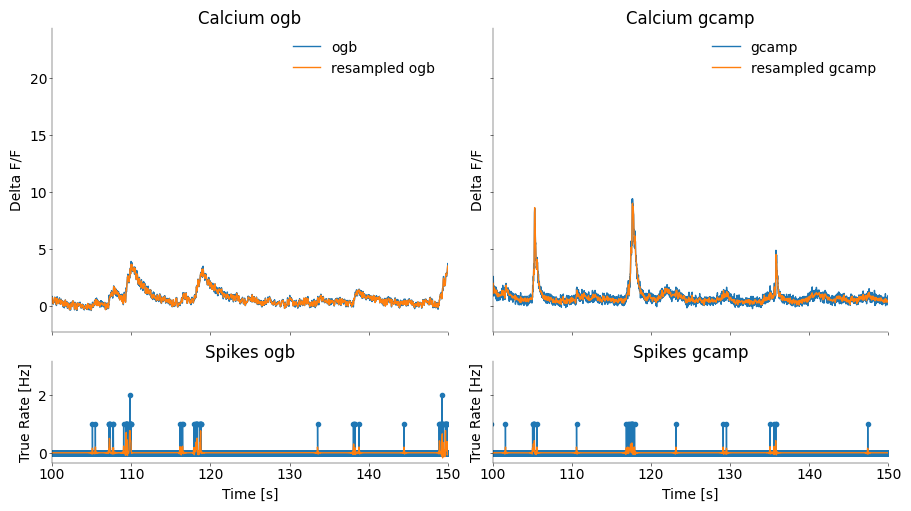

In [ ]:
good_cell_ogb = 4
good_cell_gcamp = 5

samplerate = 25
downsaple_factor = 100 / samplerate

# Calcium data
calcium_ogb_cell = ogb_calcium[f"{good_cell_ogb}"].to_numpy()
calcium_ogb_cell_dec = signal.decimate(calcium_ogb_cell, int(downsaple_factor))

calcium_gcamp_cell = gcamp_calcium[f"{good_cell_gcamp}"].to_numpy()
calcium_gcamp_cell_dec = signal.decimate(calcium_gcamp_cell, int(downsaple_factor))


# Spike data
spike_ogb_cell = ogb_spikes[f"{good_cell_ogb}"].to_numpy()
spike_ogb_cell_dec = signal.decimate(spike_ogb_cell, int(downsaple_factor))

spike_gcamp_cell = gcamp_spikes[f"{good_cell_gcamp}"].to_numpy()
spike_gcamp_cell_dec = signal.decimate(spike_gcamp_cell, int(downsaple_factor))


# --------------------------
# make new time axis

time_ogb = np.arange(0, len(calcium_ogb_cell)) / 100
time_ogb_dec = np.arange(0, len(calcium_ogb_cell_dec)) / samplerate
time_gcamp = np.arange(0, len(calcium_gcamp_cell)) / 100
time_gcamp_dec = np.arange(0, len(calcium_gcamp_cell_dec)) / samplerate

fig, axs = plt.subplots(
    2,
    2,
    figsize=(9, 5),
    height_ratios=[3, 1],
    layout="constrained",
    sharex=True,
    sharey="row",
)
xlims_ogb = [100, 150]
xlims_gcamp = [100, 150]
axs[0, 0].plot(time_ogb, calcium_ogb_cell, label="ogb")
axs[0, 0].plot(time_ogb_dec, calcium_ogb_cell_dec, label="resampled ogb")
axs[0, 0].set_title("Calcium ogb")
axs[0, 0].set_xlim(xlims_ogb)
axs[0, 0].set_ylabel("Delta F/F")
axs[0, 0].legend()


axs[0, 1].plot(time_gcamp, calcium_gcamp_cell, label="gcamp")
axs[0, 1].plot(time_gcamp_dec, calcium_gcamp_cell_dec, label="resampled gcamp")
axs[0, 1].set_title("Calcium gcamp")
axs[0, 1].set_ylabel("Delta F/F")
axs[0, 1].set_xlim(xlims_gcamp)
axs[0, 1].legend()

axs[1, 0].plot(time_ogb, spike_ogb_cell)
axs[1, 0].plot(time_ogb_dec, spike_ogb_cell_dec)
axs[1, 0].set_title("Spikes ogb")
axs[1, 0].set_xlim(xlims_ogb)
axs[1, 0].scatter(time_ogb, spike_ogb_cell)
axs[1, 0].set_ylabel("True Rate [Hz]")
axs[1, 0].set_xlabel("Time [s]")

axs[1, 1].plot(time_gcamp, spike_gcamp_cell)
axs[1, 1].plot(time_gcamp_dec, spike_gcamp_cell_dec)
axs[1, 1].scatter(time_gcamp, spike_gcamp_cell)
axs[1, 1].set_title("Spikes gcamp")
axs[1, 1].set_xlim(xlims_gcamp)
axs[1, 1].set_ylabel("True Rate [Hz]")
axs[1, 1].set_xlabel("Time [s]")


# plot raw gcamp data

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this.

*Grading: 3 pts*


In [ ]:
# %timeit deconv_ca(calcium_ogb_cell_dec, 0.5, samplerate)

def deconv_ca(ca, tau, dt):
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval. 1/samplerate

    Return
    ------

    sp_hat: np.array
    kernel: np.array
    """

    # get the filter coefficients
    coeffs = signal.butter(4, tau + 0.3, "lowpass", fs=dt, output="sos")
    # pass the filter coefficients  and the data to the filter function
    filtered_data = signal.sosfiltfilt(sos=coeffs, x=ca)

    # initialize the smoothing algorithm
    n = 0
    while n < 10000:
        # find all peaks in the filtered data
        all_peaks = signal.find_peaks(filtered_data)[0]
        diff_peaks = np.abs(np.diff(filtered_data[all_peaks]))
        # search for the smallest difference between peaks
        p_min = np.argmin(diff_peaks)
        # set the datapoints around the peak to the mean of the segment
        datapoints = 25
        segment = np.arange(
            all_peaks[p_min] - datapoints, all_peaks[p_min] + datapoints
        )
        mean_segment = signal.medfilt(
            filtered_data[segment],
            5,
        )
        # replace the datapoints with the mean
        filtered_data[segment] = mean_segment

        p_min = diff_peaks[p_min]
        # if the difference between peaks is larger than 1, break the loop
        if p_min > 1:
            break
        n += 1

    kernel = np.exp(-np.arange(0, 3 * tau, 1 / dt) / tau)
    # deconvolve the filtered data with the kernel
    sp_hat, _ = signal.deconvolve(filtered_data, kernel)

    sp_hat = np.pad(sp_hat, (0, len(filtered_data) - len(sp_hat)), "constant")
    # heavy side function
    sp_hat[sp_hat < 0] = 0

    return sp_hat, kernel


deconv_calcium_ogb_cell, ogb_kernel = deconv_ca(calcium_ogb_cell_dec, 0.5, samplerate)
deconv_calcium_gcamp_cell, gcamp_kernel = deconv_ca(
    calcium_gcamp_cell_dec, 0.1, samplerate
)

<matplotlib.legend.Legend>

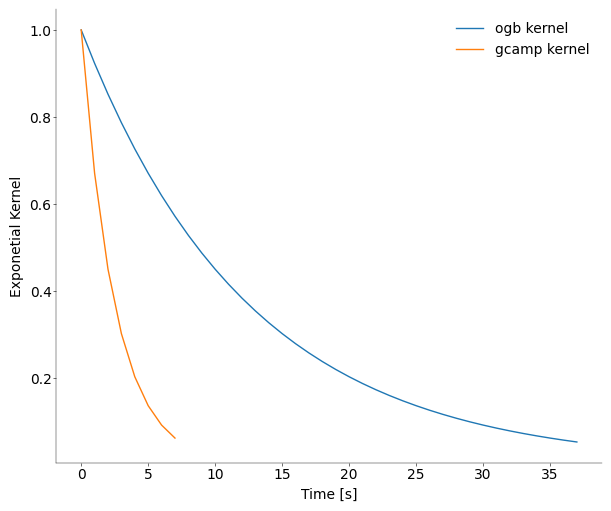

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")

ax.plot(ogb_kernel, label="ogb kernel")
ax.plot(gcamp_kernel, label="gcamp kernel")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Exponetial Kernel")
ax.legend()

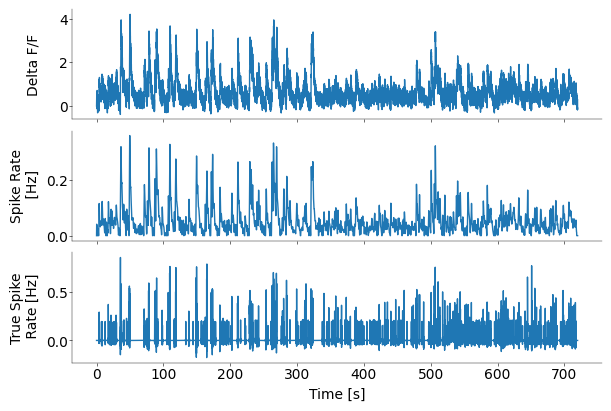

In [ ]:
# OGB
fig, axs = plt.subplots(
    3,
    1,
    figsize=(6, 4),
    height_ratios=[1, 1, 1],
    gridspec_kw=dict(hspace=0),
    sharex=True,
)

axs[0].plot(time_ogb_dec, calcium_ogb_cell_dec, label="ogb")
axs[1].plot(time_ogb_dec, deconv_calcium_ogb_cell, label="ogb dec")
axs[2].plot(time_ogb_dec, spike_ogb_cell_dec, label="ogb spike")
axs[2].set_xlabel("Time [s]")
axs[0].set_ylabel("Delta F/F")
axs[1].set_ylabel("Spike Rate\n [Hz]")
axs[2].set_ylabel("True Spike\n Rate [Hz]")
fig.align_labels()

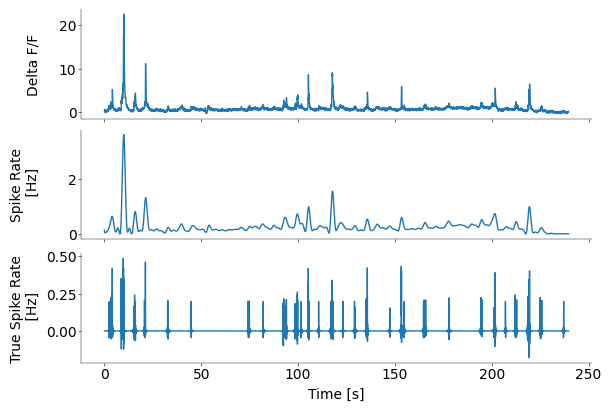

In [ ]:
# GCAMP
fig, axs = plt.subplots(
    3,
    1,
    figsize=(6, 4),
    height_ratios=[1, 1, 1],
    gridspec_kw=dict(hspace=0),
    sharex=True,
)
axs[0].plot(time_gcamp_dec, calcium_gcamp_cell_dec, label="ogb")
axs[1].plot(time_gcamp_dec, deconv_calcium_gcamp_cell, label="ogb dec")
axs[2].plot(time_gcamp_dec, spike_gcamp_cell_dec, label="ogb spike")
axs[2].set_xlabel("Time [s]")
axs[0].set_ylabel("Delta F/F")
axs[1].set_ylabel("Spike Rate\n [Hz]")
axs[2].set_ylabel("True Spike Rate\n [Hz]")
fig.align_labels()

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 2 pts*



In [ ]:
import oasis

c, s, b, g, lam = oasis.functions.deconvolve(calcium_ogb_cell_dec)

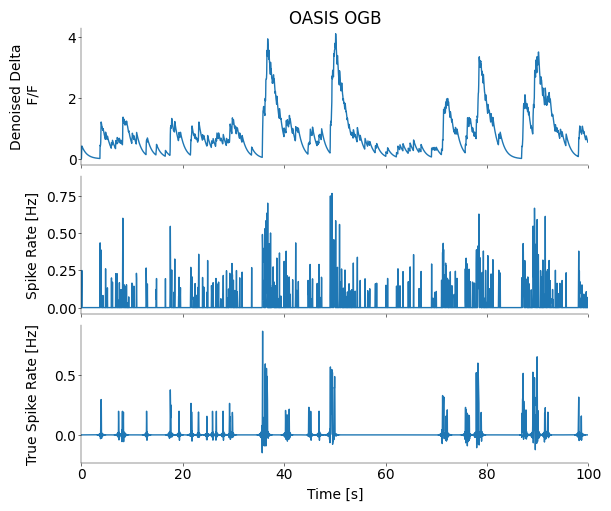

In [ ]:
fig, axs = plt.subplots(
    3,
    1,
    figsize=(6, 5),
    height_ratios=[1, 1, 1],
    gridspec_kw=dict(hspace=0),
    sharex=True,
)
axs[0].set_title("OASIS OGB")
axs[0].plot(time_ogb_dec, c, label="ogb_oasis")
axs[1].plot(time_ogb_dec, s, label="spike_oasis")
axs[2].plot(time_ogb_dec, spike_ogb_cell_dec, label="ogb spike")
axs[2].set_xlabel("Time [s]")
axs[0].set_ylabel("Denoised Delta\n F/F")
axs[1].set_ylabel("Spike Rate [Hz]")
axs[2].set_ylabel("True Spike Rate [Hz]")
axs[2].set_xlim(0, 100)
fig.align_labels()
# OGB Cell

In [ ]:
c, s, b, g, lam = oasis.functions.deconvolve(calcium_gcamp_cell_dec)

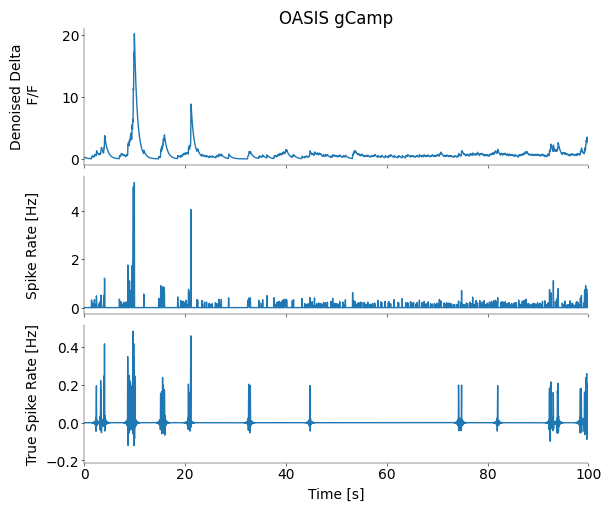

In [ ]:
fig, axs = plt.subplots(
    3,
    1,
    figsize=(6, 5),
    height_ratios=[1, 1, 1],
    gridspec_kw=dict(hspace=0),
    sharex=True,
)
axs[0].set_title("OASIS gCamp")
axs[0].plot(time_gcamp_dec, c, label="gcamp_oasis")
axs[1].plot(time_gcamp_dec, s, label="spike_oasis")
axs[2].plot(time_gcamp_dec, spike_gcamp_cell_dec, label="gcamp spike")
axs[2].set_xlabel("Time [s]")
axs[0].set_ylabel("Denoised Delta\n F/F")
axs[1].set_ylabel("Spike Rate [Hz]")
axs[2].set_ylabel("True Spike Rate [Hz]")
axs[2].set_xlim(0, 100)
fig.align_labels()

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


Evaluate on OGB data

In [ ]:
algo = []
c = []
indicator = []

for cell in range(ogb_calcium.shape[1]):
    # get the current cell out of the dataframe
    cell_calcium_data = ogb_calcium[f"{cell}"].to_numpy()[
        ~np.isnan(ogb_calcium[f"{cell}"].to_numpy())
    ]
    cell_spike_data = ogb_spikes[f"{cell}"].to_numpy()[
        ~np.isnan(ogb_spikes[f"{cell}"].to_numpy())
    ]
    # decimate the data
    gcamp_calcium_dec = signal.decimate(cell_calcium_data, int(downsaple_factor))
    spike_gcamp_cell_dec = signal.decimate(cell_spike_data, int(downsaple_factor))
    # caluclate the time array
    time_gcamp_dec = np.arange(0, len(gcamp_calcium_dec)) / samplerate

    # deconvolve the data with our function
    deconv_calcium_gcamp_cell, ogb_kernel = deconv_ca(
        gcamp_calcium_dec, 0.5, samplerate
    )
    # deconvolve the data with oasis
    ca, s, b, g, lam = oasis.functions.deconvolve(gcamp_calcium_dec)

    # calulate the correlation between spike_ogb_cell_dec and deconv_calcium_ogb_cell
    c.append(np.corrcoef(spike_gcamp_cell_dec, deconv_calcium_gcamp_cell)[0, 1])
    algo.append("Our_Algorithm")
    indicator.append("OGB")

    # calulate the correlation between spike_ogb_cell_dec and oasis
    c.append(np.corrcoef(spike_gcamp_cell_dec, s)[0, 1])
    algo.append("Oasis")
    indicator.append("OGB")

Create OGB dataframe

In [ ]:
df_ogb = pd.DataFrame({"algorithm": algo, "correlation": c, "indicator": indicator})
df_ogb.head()

,algorithm,correlation,indicator
0,Our_Algorithm,0.307022,OGB
1,Oasis,0.473556,OGB
2,Our_Algorithm,0.237009,OGB
3,Oasis,0.166155,OGB
4,Our_Algorithm,0.171644,OGB


Evaluate on GCamp data

In [ ]:
algo = []
c = []
indicator = []

for cell in range(gcamp_calcium.shape[1]):
    # get the current cell out of the dataframe
    cell_calcium_data = gcamp_calcium[f"{cell}"].to_numpy()[
        ~np.isnan(gcamp_calcium[f"{cell}"].to_numpy())
    ]
    cell_spike_data = gcamp_spikes[f"{cell}"].to_numpy()[
        ~np.isnan(gcamp_spikes[f"{cell}"].to_numpy())
    ]
    # decimate the data
    gcamp_calcium_dec = signal.decimate(cell_calcium_data, int(downsaple_factor))
    spike_gcamp_cell_dec = signal.decimate(cell_spike_data, int(downsaple_factor))

    # deconvolve the data with our function
    deconv_calcium_gcamp_cell, ogb_kernel = deconv_ca(
        gcamp_calcium_dec, 0.5, samplerate
    )
    # deconvolve the data with oasis
    ca, s, b, g, lam = oasis.functions.deconvolve(gcamp_calcium_dec)

    # calulate the correlation between spike_ogb_cell_dec and deconv_calcium_ogb_cell
    c.append(np.corrcoef(spike_gcamp_cell_dec, deconv_calcium_gcamp_cell)[0, 1])
    algo.append("Our_Algorithm")
    indicator.append("gCamp")

    # calulate the correlation between spike_ogb_cell_dec and oasis
    c.append(np.corrcoef(spike_gcamp_cell_dec, s)[0, 1])
    algo.append("Oasis")
    indicator.append("gCamp")

Create GCamp dataframe

In [ ]:
df_gcamp = pd.DataFrame({"algorithm": algo, "correlation": c, "indicator": indicator})
df_gcamp.head()

,algorithm,correlation,indicator
0,Our_Algorithm,0.491098,gCamp
1,Oasis,0.605176,gCamp
2,Our_Algorithm,0.329241,gCamp
3,Oasis,0.637547,gCamp
4,Our_Algorithm,0.435890,gCamp


Combine both dataframes and plot

In [ ]:
df = pd.concat([df_ogb, df_gcamp])
df

,algorithm,correlation,indicator
0,Our_Algorithm,0.307022,OGB
1,Oasis,0.473556,OGB
2,Our_Algorithm,0.237009,OGB
3,Oasis,0.166155,OGB
4,Our_Algorithm,0.171644,OGB
...,...,...,...
69,Oasis,0.622005,gCamp
70,Our_Algorithm,0.476977,gCamp
71,Oasis,0.592172,gCamp
72,Our_Algorithm,0.385621,gCamp


<Axes: xlabel='correlation', ylabel='indicator'>

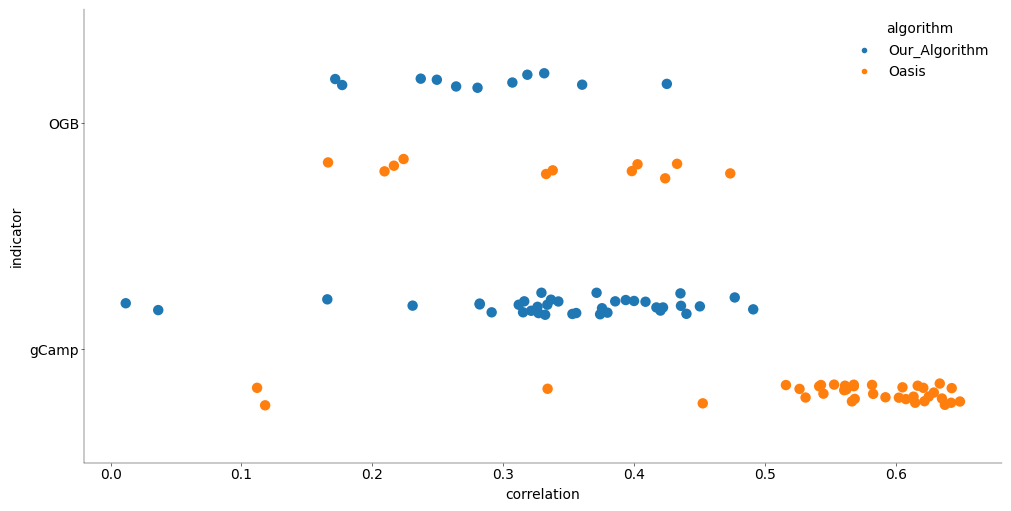

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5), sharey=True)
sns.stripplot(
    data=df,
    y=df["indicator"],
    x=df["correlation"],
    hue=df["algorithm"],
    dodge=True,
    size=15,
)